We first list the basic function in Pytorch and consider a very simple example to understand how Grandient Descent can be implemented. Then we illustrate how set the architecture of neural nets and run it on MNIST dataset. Lastly, we provide an implementation of CNN.

Then, we propose to implement logistic regression as a neural net and to also to add dropout in CNN.

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import pandas as pd

In [2]:
x = torch.rand(3, 3) # random tensor of size 3 by 3
print(x)

tensor([[0.8601, 0.5106, 0.1078],
        [0.6677, 0.3168, 0.0983],
        [0.6456, 0.5137, 0.7019]])


In [3]:
x = torch.ones(3,3)
y = torch.ones(3,3) * 4
z = x + y
print(f'This is the result of:\n {x}\n +\n {y} \n = \n {z}')

This is the result of:
 tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
 +
 tensor([[4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.]]) 
 = 
 tensor([[5., 5., 5.],
        [5., 5., 5.],
        [5., 5., 5.]])


In [4]:
# again we can operate with tensor indexing as if it was a numpy one

x = torch.ones(3,3) * 5
y = x[-1, :2]
print(f'From \n {x} we can look at the last column and 2 rows \n {y}')



From 
 tensor([[5., 5., 5.],
        [5., 5., 5.],
        [5., 5., 5.]]) we can look at the last column and 2 rows 
 tensor([5., 5.])


**Example**

A lot of ML algorithms can be stated as optimization problems.
Let us consider a toy example: imagine that our data is $x = (1, \ldots, 1)^\top \in \mathbb{R}^{5}$ is a vector composed of all ones and a label $y = 1$. We would like to find a weight vector $w \in \mathbb{R}^{5}$ such that the loss function $L(w) = (y - x^\top w)^2$ is minimized.

Of course, this is a simple least squares on a single observation $(x, y)$ and we can compute the result analytically. 

If we are too lazy to compute the analytic expression, we can run the Gradient Descent, which starts from $w_0 = (0, \ldots, 0)^\top$ and proceeds as

$$w_k = w_{k - 1} - \eta \nabla L(w_{k - 1}).$$

So the only thing that we need to know is the gradient of the loss function $L$ evaluated at the point $w_{k - 1}$.
Here how it is done in pytorch.

In [5]:
# Input data
y = torch.ones(1, 1)
x = torch.ones(1, 5)

# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these tensors during the backward pass.
w = torch.zeros(5, 1, requires_grad=True) # setting w_0 = (0, ..., 0)^T

y_pred = x.mm(w) # inner product of w and x 

loss = (y - y_pred).pow(2) # squared loss

# Use autograd to compute the backward pass. This call will compute the
# gradient of loss with respect to all tensors with requires_grad=True.
# After this call w.grad will be a tensor holding the gradient
# of the loss with respect to w.
loss.backward()
print(w.grad) # Print the gradient

tensor([[-2.],
        [-2.],
        [-2.],
        [-2.],
        [-2.]])


c:\users\lilia\appdata\local\programs\python\python37\lib\site-packages\torch\autograd\__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


In [6]:
# Input data
y = torch.ones(1, 1)
x = torch.ones(1, 5)

# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these tensors during the backward pass.
w = torch.zeros(5, 1, requires_grad=True) # Initialization: w_0 = (0, ..., 0)^T

lr = .01 # Learning rate a.k.a. the step size
max_iter = 150

for k in range(max_iter):
    y_pred = x.mm(w) # inner product of w and x 
    loss = (y - y_pred).pow(2) # forward pass # squared loss   
    loss.backward() # the backward pass
    
    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        w -= lr * w.grad # gradient step
        w.grad.zero_() # after performing operation with gradient we need to erase it
    
    if k % 10 == 9:
        print(f'Iteration {k + 1}/{max_iter}, Current loss: {loss.item()}')
        
print(f'Final result: {w}')

Iteration 10/150, Current loss: 0.150094673037529
Iteration 20/150, Current loss: 0.018248017877340317
Iteration 30/150, Current loss: 0.002218528650701046
Iteration 40/150, Current loss: 0.00026972233899869025
Iteration 50/150, Current loss: 3.279230440966785e-05
Iteration 60/150, Current loss: 3.986556748714065e-06
Iteration 70/150, Current loss: 4.846697265747935e-07
Iteration 80/150, Current loss: 5.8908199207508005e-08
Iteration 90/150, Current loss: 7.173785121494802e-09
Iteration 100/150, Current loss: 8.74024408403784e-10
Iteration 110/150, Current loss: 1.0756195933936397e-10
Iteration 120/150, Current loss: 1.3219647598816664e-11
Iteration 130/150, Current loss: 1.566746732351021e-12
Iteration 140/150, Current loss: 1.7408297026122455e-13
Iteration 150/150, Current loss: 1.2789769243681803e-13
Final result: tensor([[0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000]], requires_grad=True)


# Multi layer perceptron

Below we will build our neural net. Recall that MNIST is composed of images of size $28 \times 28$, hence the dimenison of the input is $784$. We have $10$ classes, so the dimension of the output is $10$.

In between we will insert $2$ hidden layers and use ReLU as our non-linearity (activation function).
The first hidden layer is composed of $128$ neurons and the second one of $64$ neurons.

We will not use GPU nor we will consider complicated neural nets in this TP. The goal is to introduce you to the basics without going into too complicated architechtures.

In [7]:
class SimpleFeedForward(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[128, 64],
                 output_size=10):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]), 
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], output_size)
        )
             
    def forward(self, x):
        x = x.reshape(-1, input_size)
        x = self.classifier(x)
        return x

Once we defined our neural net we need to train it.
The training is going to be performed via Stochastic Gradient Descent evaluated on a mini batch of the data.
That is, on the foward stage we will use not a single data point but several ones. In this case we set the size of mini batch equal to $32$.

In [8]:
# Training consists of gradient steps over mini batch of data
def train(model, trainloader, loss, optimizer, epoch, num_epochs):
    # We enter train mode. This is useless for the linear model
    # but is important for layers such as dropout, batchnorm, ...
    model.train()
    
    loop = tqdm(trainloader)
    loop.set_description(f'Training Epoch [{epoch + 1}/{num_epochs}]')
    
    # We iterate over the mini batches of our data
    for inputs, targets in loop:
    
        # Erase any previously stored gradient
        optimizer.zero_grad()
        
        
        outputs = net(inputs) # Forwards stage (prediction with current weights)
        loss = criterion(outputs, targets) # loss evaluation
        
        loss.backward() # Back propagation (evaluate gradients) 
        
        
        # Making gradient step on the batch (this function takes care of the gradient step for us)
        optimizer.step() 
        
def validation(model, valloader, loss):
    # Do not compute gradient, since we do not need it for validation step
    with torch.no_grad():
        # We enter evaluation mode.
        model.eval()
        
        total = 0 # keep track of currently used samples
        running_loss = 0.0 # accumulated loss without averagind
        accuracy = 0.0 # accumulated accuracy without averagind (number of correct predictions)
        
        loop = tqdm(valloader) # This is for the progress bar
        loop.set_description('Validation in progress')
        
        
        # We again iterate over the batches of validation data. batch_size does not play any role here
        for inputs, targets in loop:
            # Run samples through our net
            outputs = model(inputs)

            # Total number of used samples
            total += inputs.shape[0]

            # Multiply loss by the batch size to erase averagind on the batch
            running_loss += inputs.shape[0] * loss(outputs, targets).item()
            
            # how many correct predictions
            accuracy += (outputs.argmax(dim=1) == targets).sum().item()
            
            # set nice progress meassage
            loop.set_postfix(val_loss=(running_loss / total), val_acc=(accuracy / total))
        return running_loss / total, accuracy / total

We use again the MNIST dataset. This time we will use the official train/test split!

In [9]:
# We download the official MNIST train set
all_train = datasets.MNIST('data/',
                           download=True,
                           train=True,
                           transform=transforms.ToTensor())

# We split the whole train set in two parts:
# the one that we actually use for training
# and the one that we use for validation
batch_size = 32 # size of the mini batch
num_train = int(0.8 * len(all_train))

trainset, valset = torch.utils.data.random_split(all_train, [num_train, len(all_train) - num_train])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

Dimensions of the inputs are torch.Size([32, 1, 28, 28])
The number on the image is: 7


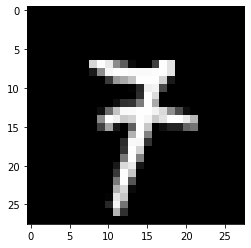

In [10]:
# we can iterate over trainloader in the following way
for inputs, targets in trainloader:
    print(f'Dimensions of the inputs are {inputs.shape}')
    plt.imshow(inputs[0][0], cmap='gray', interpolation='none')
    print(f'The number on the image is: {targets[0]}')
    break

The shape of ```inputs``` is $(32, 1, 28, 28)$. The first dimension indicates the size of the mini batch and is controlled by parameter ```batch_size```, the last two parameters are the 2D dimensions of the image and are equal to $28 \times 28$ in case of the MNIST data. The lonely $1$, staying in the second dimension essentialy reflects the fact that the images are black and white. For instance, if MNIST were colored (there are variants of colored MNIST actually), then we would need $3$ (in case of RGB) colors to represent an image, thus $1$ would be replaed by $3$. 

In [11]:
# Net + training parameters
num_epochs = 2 # how many passes over the whole train data
input_size = 784 # flattened size of the image
hidden_sizes = [128, 64] # sizes of hidden layers
output_size = 10 # how many labels we have
lr = 0.001 # learning rate
momentum = 0.9 # momentum

In [12]:
# initializing our model/loss/optimizer
net = SimpleFeedForward(input_size, hidden_sizes, output_size) # Our neural net
criterion = nn.CrossEntropyLoss() # Loss function to be optimized
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum) # Optimization algorithm

In [13]:
# num_epochs indicates the number of passes over the data
for epoch in range(num_epochs):
    
    # makes one pass over the train data and updates weights
    train(net, trainloader, criterion, optimizer, epoch, num_epochs)

    # makes one pass over validation data and provides validation statistics
    val_loss, val_acc = validation(net, valloader, criterion)


In [14]:
# Let us evaluate our net on the test set that we have never seen!
testset = datasets.MNIST('data/',
                         download=True,
                         train=False,
                         transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

test_loss, test_acc = validation(net, testloader, criterion)
print(f'Test accuracy: {test_acc} | Test loss: {test_loss}')


Test accuracy: 0.8984 | Test loss: 0.34937377161979677


# Problem 1: Logistic regression via pytorch

In [15]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size=784, output_size=10):
        super(LogisticRegression, self).__init__()
        self.classifier = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = x.reshape(-1, input_size)
        x = self.classifier(x)
        return x

# Net + training parameters
num_epochs = 5 # how many passes over the whole train data
input_size = 784 # flattened size of the image
output_size = 10 # how many labels we have
lr = 0.001 # learning rate
momentum = 0.9 # momentum
perfs = []

net = LogisticRegression(input_size, output_size) # Our neural net

criterion = nn.CrossEntropyLoss() # Loss function to be optimized

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum) # Optimization algorithm

# num_epochs indicates the number of passes over the data
for epoch in range(num_epochs):
    
    # makes one pass over the train data and updates weights
    train(net, trainloader, criterion, optimizer, epoch, num_epochs)

    # makes one pass over validation data and provides validation statistics
    val_loss, val_acc = validation(net, valloader, criterion)
    perfs.append([epoch, val_loss, val_acc])


# Let us evaluate our net on the test set that we have never seen!
testset = datasets.MNIST('data/',
                         download=True,
                         train=False,
                         transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

test_loss, test_acc = validation(net, testloader, criterion)
print(f'Test accuracy: {test_acc} | Test loss: {test_loss}')


Test accuracy: 0.9073 | Test loss: 0.3461409924030304


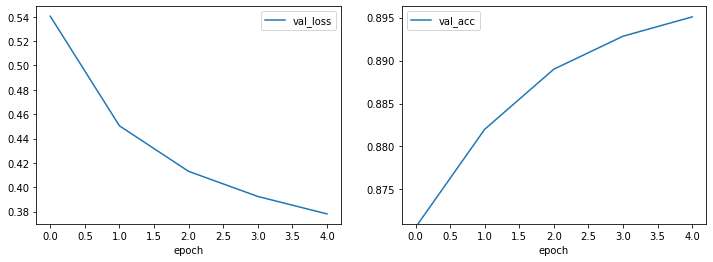

In [17]:
df_perfs = pd.DataFrame(perfs, columns=["epoch", "val_loss", "val_acc"]).set_index("epoch")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df_perfs[["val_loss"]].plot(ax=ax1);
df_perfs[["val_acc"]].plot(ax=ax2);
plt.ylim(ymin=0.871);

# Elements of CNN: ```nn.Conv2d``` and ```MaxPool2d```

**Convolutional layer in pytorch**

Once we instanciate ```nn.Conv2d(1, 1, kernel_size=2, stride=[1, 1], padding=0)``` it has a parameter ```weight``` which precisely describes the kernel used for our convolution. In the beginning it is initialized randomly, and our goal is to eventually learn its weights (as usual via backpropagation!).

In [18]:
# 1 input channel (first 1 in nn.Conv2d)
# 1 output channel (second 1 in nn.Conv2d)
# 2x2 kernel (kernel_size=2)
# the kernel slides by one step in (x, y) direction (stride=[1, 1])
# we do not augment the picture with white borders (padding=0)
conv = nn.Conv2d(1, 1, kernel_size=2, stride=[1, 1], padding=0) 
# Get kernel value.
weight = conv.weight.data.numpy()

**Visualization.** We will plot the initial image, the kernel, and the resulting image. In order to understand what is going on, the resulting image will be computed in two ways. First of all it will be computed by using ```conv1(image)```. Secondly, we will manually apply the sliding kernel to each $2\times 2$ window.

Text(0.5, 1.0, 'By hand')

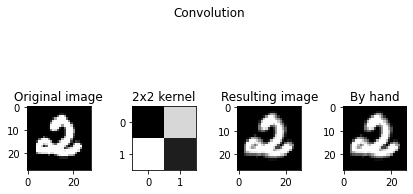

In [20]:
# take one image
image, _ = next(iter(trainloader))


fig, axs = plt.subplots(1, 4)
fig.tight_layout()
fig.suptitle('Convolution')

# plot the image
axs[0].imshow(image[0][0], cmap='gray', interpolation='none')
axs[0].set_title('Original image')

# plot the kernel
axs[1].imshow(weight[0][0], cmap='gray', interpolation='none')
axs[1].set_title('2x2 kernel')

# plot resulting image
axs[2].imshow(conv(image)[0][0].detach().numpy(), cmap='gray', interpolation='none')
axs[2].set_title('Resulting image')

# Making the same by hands
np_image = image[0][0].data.numpy() # get numpy image
image_convolved = np.zeros((27, 27)) # here we store our result
for i in range(27):
    for j in range(27):
        image_convolved[i, j] = np.sum(np_image[i:i+2, j:j+2] * weight) # apply the kernel for each 2x2 window
        
axs[3].imshow(image_convolved, cmap='gray', interpolation='none')
axs[3].set_title('By hand')

**Problem.** Provide 'by hand' implementation of the following kernel 

Text(0.5, 1.0, 'By hand')

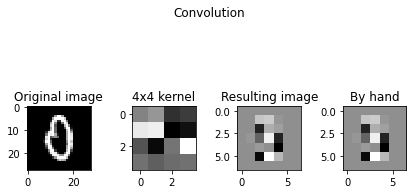

In [21]:
# 1 input channel (first 1 in nn.Conv2d)
# 1 output channel (second 1 in nn.Conv2d)
# 4x4 kernel (kernel_size=4)
# the kernel slides by 3 step in (x, y) direction (stride=[4, 4])
# we do not augment the picture with white borders (padding=0)
conv = nn.Conv2d(1, 1, kernel_size=4, stride=[4, 4], padding=0) 
# Get kernel value.
weight = conv.weight.data.numpy()

# take one image
image, _ = next(iter(trainloader))

fig, axs = plt.subplots(1, 4)
fig.tight_layout()
fig.suptitle('Convolution')

# plot the image
axs[0].imshow(image[0][0], cmap='gray', interpolation='none')
axs[0].set_title('Original image')

# plot the kernel
axs[1].imshow(weight[0][0], cmap='gray', interpolation='none')
axs[1].set_title('4x4 kernel')

# plot resulting image
axs[2].imshow(conv(image)[0][0].detach().numpy(), cmap='gray', interpolation='none')
axs[2].set_title('Resulting image')

# Making the same by hands
np_image = image[0][0].data.numpy() # get numpy image
image_convolved = np.zeros((7, 7)) # here we store our result
for i in range(7):
    for j in range(7):
        image_convolved[i, j] = np.sum(np_image[(i*4):(i*4)+4, (j*4):(j*4)+4] * weight) # apply the kernel for each 4x4  window

axs[3].imshow(image_convolved, cmap='gray', interpolation='none')
axs[3].set_title('By hand')

**Pooling layer in pytorch**

Max pooling is what often used in practice, it amounts to picking only the largest value of a pixel in a given window. In pytorch it is done via ```MaxPool2d(kernel_size=k, stride=s)```, which has two parameters: kernel size and the stride. Note that there are no weights to learn here, so this layer is simply fixed.

Text(0.5, 1.0, 'By hand')

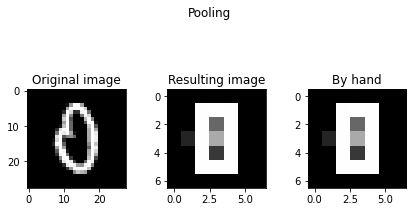

In [22]:
# kernel_size -- size of the max pool window
pool = nn.MaxPool2d(kernel_size=4, stride=[4,4])

fig, axs = plt.subplots(1, 3)
fig.tight_layout()
fig.suptitle('Pooling')

# plot the image
axs[0].imshow(image[0][0], cmap='gray', interpolation='none')
axs[0].set_title('Original image')


# plot resulting image
axs[1].imshow(pool(image)[0][0].detach().numpy(), cmap='gray', interpolation='none')
axs[1].set_title('Resulting image')

# Making the same by hands
# IMPORTANT: we strongly suggest to understand the below code
np_image = image[0][0].data.numpy() # get numpy image
image_pooled = np.zeros((7, 7)) # here we store our result
for i in range(0, 27, 4):
    for j in range(0, 27, 4):
        image_pooled[int(i / 4), int(j / 4)] = np.max(np_image[i:i+4, j:j+4]) # max pooling
        
axs[2].imshow(image_pooled, cmap='gray', interpolation='none')
axs[2].set_title('By hand')

# Bulding a simple ConvNet

In [23]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=[1, 1], padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.classifier = nn.Sequential(
            nn.Linear(14 * 14 * 8, 500),
            nn.ReLU(),
            nn.Linear(500, 10),
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out)
        return out

Note that the first layer is ```nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)```, the parameters here are chosen in such a way that the size of each output channel remains as $28 \times 28$. Indeed, setting ```padding = 2``` we augmented our initial image to $32 \times 32$, then we slide a kernel of size $5 \times 5$ by $1$ in both $(x, y)$ directions which result in a $28 \times 28$ output image (and $8$ channels).

In general the formula for square images and squared kernels is
$$
    S_{out} = \frac{S_{in} - S_{kernel} + 2S_{padding}}{S_{stride}} + 1
$$

In our case it is

$$
    S_{out} = \frac{28 - 5 + 4}{1} + 1 = 28
$$

Then the output of ```nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2)``` goes into ```nn.ReLU()``` our favorite non-linearity and eventually into the pooling layer ```nn.MaxPool2d(kernel_size=2, stride=2)```.
The ```nn.ReLU()``` doe not affect the size, hence ```nn.MaxPool2d(kernel_size=2, stride=2)``` receives $8$ channels of $28 \times 28$ images as computed above.

```nn.MaxPool2d(kernel_size=2, stride=2)``` will be applied to each single channel, with ```kernel_size=2, stride=2``` meaning that the output will still have $8$ channels but the images will be halfed in both $(x, y)$ directions. Hence the output of ```nn.MaxPool2d(kernel_size=2, stride=2)``` has $8$ channels with $14 \times 14$ images.

After all this, we will flatten our features and put the into simple ```nn.Linear(14 * 14 * 8, 500)```, where the input size is precisely the output size of ```nn.MaxPool2d(kernel_size=2, stride=2)```, and $500$ stands for the output size of this linear layer.
Finally, we apply our favorite nonlinearity to ```nn.Linear(14 * 14 * 8, 500)``` followed by fully connected linear layer ```nn.Linear(500, 10)``` to match the dimension of $10$ classes.

In [24]:
net = ConvNet()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

for epoch in range(num_epochs):
    
    # makes one pass over the train data and updates weights
    train(net, trainloader, criterion, optimizer, epoch, num_epochs)

    # makes one pass over validation data and provides validation statistics
    val_loss, val_acc = validation(net, valloader, criterion)

In [25]:
test_loss, test_acc = validation(net, testloader, criterion)
print(f'Test accuracy: {test_acc} | Test loss: {test_loss}')


Test accuracy: 0.9864 | Test loss: 0.04489561257379828


As we see the result here is much better, than in the simple multilayer perceptron. But note, we have actualy trained muuuuuch more parameters here and, at least on my computer, it takes considerably more time.

# Problem 2: Dropout

In [26]:
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=[1, 1], padding=2),
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.classifier = nn.Sequential(
            nn.Linear(14 * 14 * 8, 500),
            nn.ReLU(),
            nn.Linear(500, 10),
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.classifier(out)
        return out

In [27]:
net = ConvNet2()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

for epoch in range(num_epochs):
    
    # makes one pass over the train data and updates weights
    train(net, trainloader, criterion, optimizer, epoch, num_epochs)

    # makes one pass over validation data and provides validation statistics
    val_loss, val_acc = validation(net, valloader, criterion)

In [28]:
test_loss, test_acc = validation(net, testloader, criterion)
print(f'Test accuracy: {test_acc} | Test loss: {test_loss}')


Test accuracy: 0.9838 | Test loss: 0.049502599986456335
